<a href="https://colab.research.google.com/github/Sitaraman-lab/Notebooks/blob/main/Bonus_CAVE_tutorial_491B(Modified_from_SeungLab_Github).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install caveclient
!pip install seaborn


import caveclient
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

client = caveclient.CAVEclient()
client.auth.setup_token(make_new=True)

my_token = "7cb9fc1cc7b52149ecaa870c120b731f"
client.auth.save_token(token=my_token, overwrite=True)

datastack_name = "flywire_fafb_public"
client = caveclient.CAVEclient(datastack_name)


print("Client initialized and libraries imported.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.0/91.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.6 MB/s eta 0:00:00
New Tokens need to be acquired by hand. Please follow the following steps:
                1) Go to: https://global.daf-apis.com/auth/api/v1/create_token to create a new token.
                2) Log in with your Google credentials and copy the token shown afterward.
                3a) Save it to your computer with: client.auth.save_token(token="PASTE_YOUR_TOKEN_HERE")
                or
                3b) Set it for the current session only with client.auth.token = "PASTE_YOUR_TOKEN_HERE"
                Note: If you need to save or load multiple tokens, please read the documentation for details.
                Warning! Creating a new token by finishing step 2 will invalidate the previous token!
Client initialized and libraries imported.


### Prepare Annotation DataFrames

This section prepares all necessary annotation dataframes (Super Class, Flow, Class, Cell Type) and their respective 'pre_' and 'post_' versions, along with unique categories for plotting.

In [2]:
# Super Class Annotations
super_class_annos_df = client.materialize.query_table("hierarchical_neuron_annotations", filter_equal_dict={"classification_system": "super_class"})
unique_super_class = super_class_annos_df["cell_type"].unique()

pre_super_class_annos_df = super_class_annos_df[["pt_root_id", "cell_type"]].rename(
    columns={"pt_root_id": "pre_pt_root_id", "cell_type": "pre_super_class"})
post_super_class_annos_df = super_class_annos_df[["pt_root_id", "cell_type"]].rename(
    columns={"pt_root_id": "post_pt_root_id", "cell_type": "post_super_class"})
print("Super Class annotation dataframes prepared.")

# Flow Annotations
flow_annos_df = client.materialize.query_table("hierarchical_neuron_annotations", filter_equal_dict={"classification_system": "flow"})
unique_flow = flow_annos_df["cell_type"].unique()

pre_flow_annos_df = flow_annos_df[["pt_root_id", "cell_type"]].rename(
    columns={"pt_root_id": "pre_pt_root_id", "cell_type": "pre_flow"})
post_flow_annos_df = flow_annos_df[["pt_root_id", "cell_type"]].rename(
    columns={"pt_root_id": "post_pt_root_id", "cell_type": "post_flow"})
print("Flow annotation dataframes prepared.")

# Class Annotations
# First, get all 'cell_class' and 'cell_type' from hierarchical_neuron_annotations
cell_class_type_annos_df = client.materialize.query_table("hierarchical_neuron_annotations", filter_in_dict={"classification_system": ["cell_class", "cell_type"]})
class_annos_df = cell_class_type_annos_df[cell_class_type_annos_df['classification_system'] == 'cell_class']
unique_class = class_annos_df["cell_type"].unique()

pre_class_annos_df = class_annos_df[["pt_root_id", "cell_type"]].rename(
    columns={"pt_root_id": "pre_pt_root_id", "cell_type": "pre_class"})
post_class_annos_df = class_annos_df[["pt_root_id", "cell_type"]].rename(
    columns={"pt_root_id": "post_pt_root_id", "cell_type": "post_class"})
print("Class annotation dataframes prepared.")

# Cell Type Annotations
cell_type_annos_df = cell_class_type_annos_df[cell_class_type_annos_df['classification_system'] == 'cell_type']
unique_cell_type = cell_type_annos_df["cell_type"].unique()
# Get top 10 cell types for plotting
top_20_cell_types = cell_type_annos_df['cell_type'].value_counts().nlargest(20).index.tolist()

pre_cell_type_annos_df = cell_type_annos_df[["pt_root_id", "cell_type"]].rename(
    columns={"pt_root_id": "pre_pt_root_id", "cell_type": "pre_cell_type"})
post_cell_type_annos_df = cell_type_annos_df[["pt_root_id", "cell_type"]].rename(
    columns={"pt_root_id": "post_pt_root_id", "cell_type": "post_cell_type"})
print("Cell Type annotation dataframes and top 10 list prepared.")

Super Class annotation dataframes prepared.
Flow annotation dataframes prepared.
Class annotation dataframes prepared.
Cell Type annotation dataframes and top 10 list prepared.


### Define `plot_synaptic_distributions` Function

This function takes a `root_id` and generates countplots for presynaptic and postsynaptic partners across Super Class, Flow, Class, and the top 10 Cell Types.

In [4]:
def plot_synaptic_distributions(root_id):
    print(f"\n--- Analyzing Synaptic Distributions for Root ID: {root_id} ---")

    # 1. Load presynaptic and postsynaptic dataframes for the given root_id
    presyn_df = client.materialize.query_view("valid_synapses_nt_np_v6", filter_in_dict={"pre_pt_root_id": [root_id]})
    postsyn_df = client.materialize.query_view("valid_synapses_nt_np_v6", filter_in_dict={"post_pt_root_id": [root_id]})

    print(f"Found {len(presyn_df)} presynapses and {len(postsyn_df)} postsynapses for {root_id}.")

    # 2. For Super Class analysis
    print("\n--- Super Class Analysis ---")
    post_syn_super_df = pd.merge(postsyn_df, pre_super_class_annos_df, on="pre_pt_root_id")
    pre_syn_super_df = pd.merge(presyn_df, post_super_class_annos_df, on="post_pt_root_id")

    plt.subplots(figsize=(12, 4))
    sns.countplot(post_syn_super_df, x="pre_super_class", order=unique_super_class)
    plt.xticks(rotation=90)
    plt.title(f"Presynaptic Super Class Distribution for {root_id}")
    plt.tight_layout()
    plt.show()

    plt.subplots(figsize=(12, 4))
    sns.countplot(pre_syn_super_df, x="post_super_class", order=unique_super_class)
    plt.xticks(rotation=90)
    plt.title(f"Postsynaptic Super Class Distribution for {root_id}")
    plt.tight_layout()
    plt.show()

    # 3. For Flow analysis
    print("\n--- Flow Analysis ---")
    post_syn_flow_df = pd.merge(postsyn_df, pre_flow_annos_df, on="pre_pt_root_id")
    pre_syn_flow_df = pd.merge(presyn_df, post_flow_annos_df, on="post_pt_root_id")

    plt.subplots(figsize=(12, 4))
    sns.countplot(post_syn_flow_df, x="pre_flow", order=unique_flow)
    plt.xticks(rotation=90)
    plt.title(f"Presynaptic Flow Distribution for {root_id}")
    plt.tight_layout()
    plt.show()

    plt.subplots(figsize=(12, 4))
    sns.countplot(pre_syn_flow_df, x="post_flow", order=unique_flow)
    plt.xticks(rotation=90)
    plt.title(f"Postsynaptic Flow Distribution for {root_id}")
    plt.tight_layout()
    plt.show()

    # 4. For Class analysis
    print("\n--- Class Analysis ---")
    post_syn_class_df = pd.merge(postsyn_df, pre_class_annos_df, on="pre_pt_root_id")
    pre_syn_class_df = pd.merge(presyn_df, post_class_annos_df, on="post_pt_root_id")

    plt.subplots(figsize=(12, 6))
    sns.countplot(post_syn_class_df, x="pre_class", order=unique_class)
    plt.xticks(rotation=90)
    plt.title(f"Presynaptic Class Distribution for {root_id}")
    plt.tight_layout()
    plt.show()

    plt.subplots(figsize=(12, 6))
    sns.countplot(pre_syn_class_df, x="post_class", order=unique_class)
    plt.xticks(rotation=90)
    plt.title(f"Postsynaptic Class Distribution for {root_id}")
    plt.tight_layout()
    plt.show()

    # 5. For Top 10 Cell Types analysis
    print("\n--- Top 10 Cell Types Analysis ---")
    post_syn_cell_type_df = pd.merge(postsyn_df, pre_cell_type_annos_df, on="pre_pt_root_id")
    pre_syn_cell_type_df = pd.merge(presyn_df, post_cell_type_annos_df, on="post_pt_root_id")

    post_syn_cell_type_df_filtered = post_syn_cell_type_df[post_syn_cell_type_df['pre_cell_type'].isin(top_10_cell_types)]
    pre_syn_cell_type_df_filtered = pre_syn_cell_type_df[pre_syn_cell_type_df['post_cell_type'].isin(top_10_cell_types)]

    plt.subplots(figsize=(12, 6))
    sns.countplot(post_syn_cell_type_df_filtered, x="pre_cell_type", order=top_10_cell_types)
    plt.xticks(rotation=90)
    plt.title(f"Presynaptic Top 10 Cell Type Distribution for {root_id}")
    plt.tight_layout()
    plt.show()

    plt.subplots(figsize=(12, 6))
    sns.countplot(pre_syn_cell_type_df_filtered, x="post_cell_type", order=top_10_cell_types)
    plt.xticks(rotation=90)
    plt.title(f"Postsynaptic Top 10 Cell Type Distribution for {root_id}")
    plt.tight_layout()
    plt.show()
    print(f"Analysis for Root ID: {root_id} complete.")

print("plot_synaptic_distributions function defined.")

plot_synaptic_distributions function defined.


### Execute Analysis for Multiple Root IDs

This section defines a list of root IDs and then calls the `plot_synaptic_distributions` function for each ID to generate the plots.

plot_synaptic_distributions function updated (locally redefined to show top 20 cell types).
Generating synaptic distribution plots for the specified root IDs...

--- Analyzing Synaptic Distributions for Root ID: 720575940623182847 ---
Found 8864 presynapses and 3510 postsynapses for 720575940623182847.

--- Super Class Analysis ---


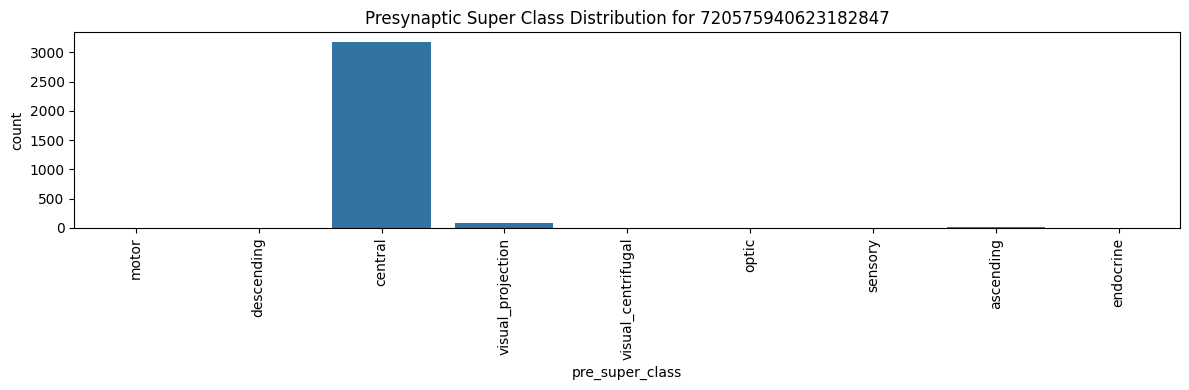

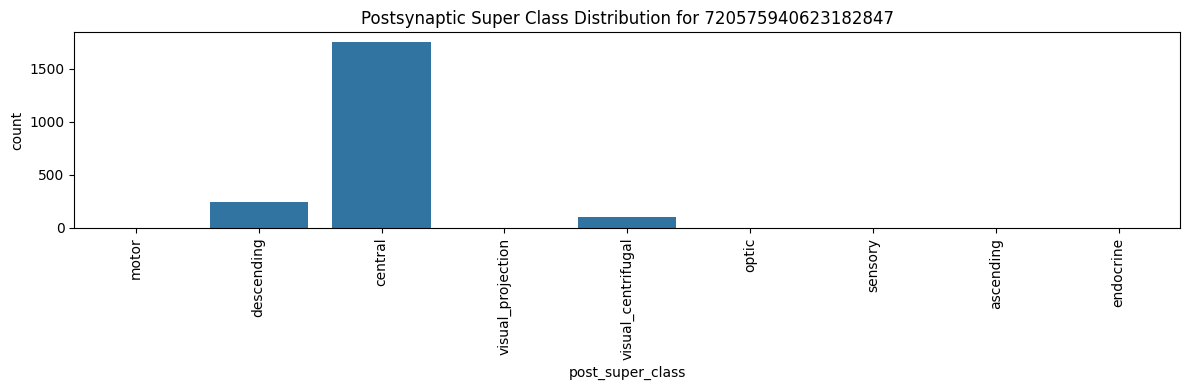


--- Flow Analysis ---


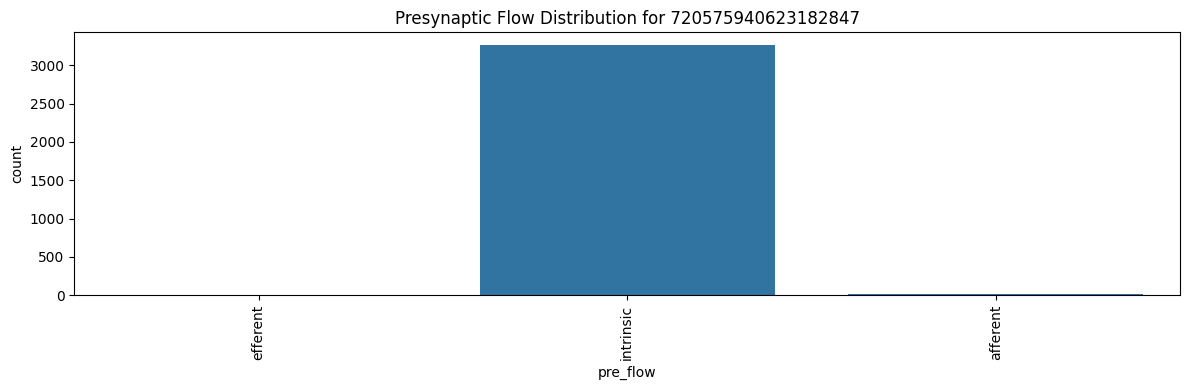

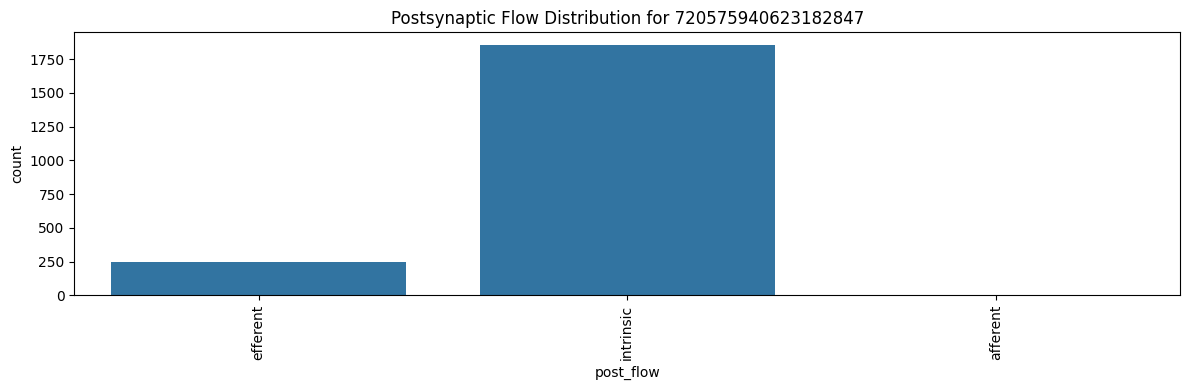


--- Class Analysis ---


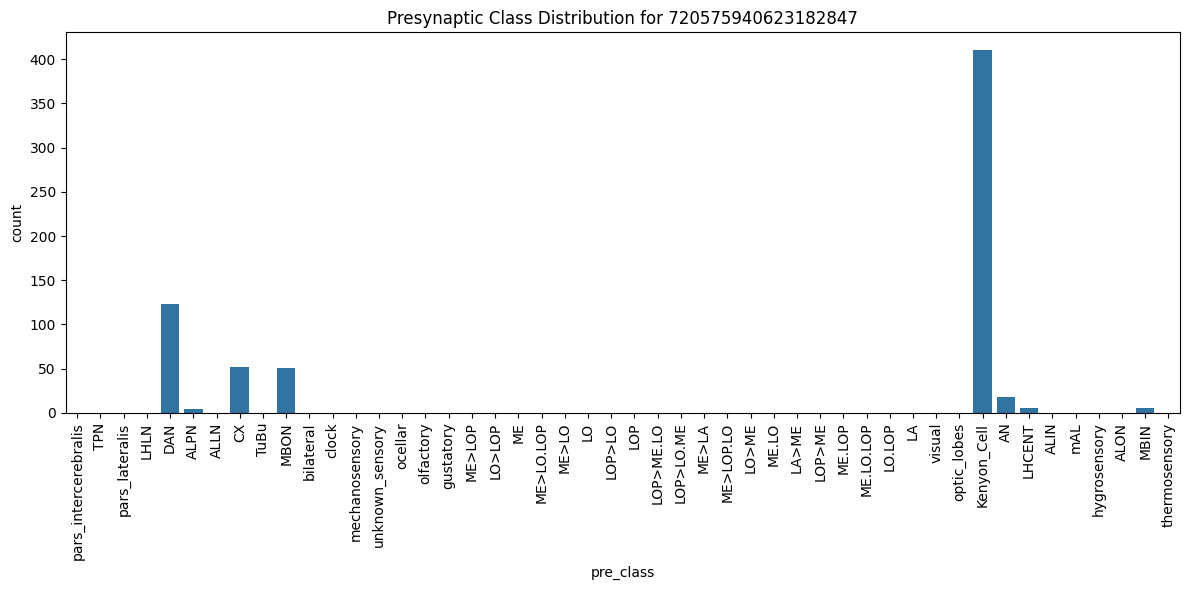

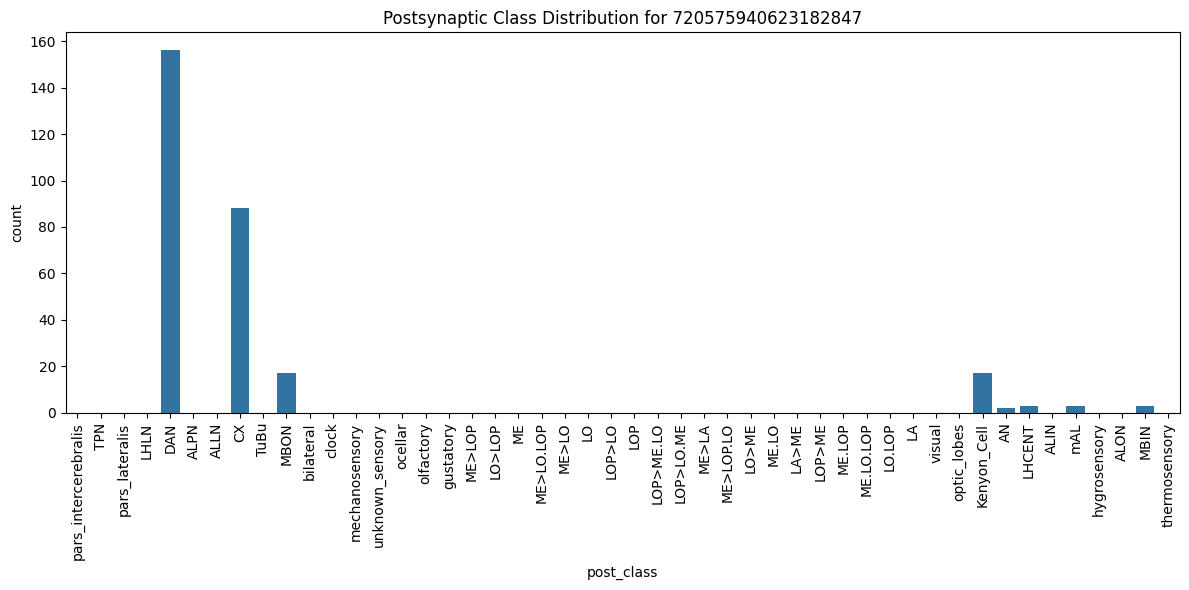


--- Top 20 Cell Types Analysis ---
No presynaptic top 20 cell type data to plot for 720575940623182847.
No postsynaptic top 20 cell type data to plot for 720575940623182847.
Analysis for Root ID: 720575940623182847 complete.

--- Analyzing Synaptic Distributions for Root ID: 720575940624280328 ---
Found 8986 presynapses and 3143 postsynapses for 720575940624280328.

--- Super Class Analysis ---


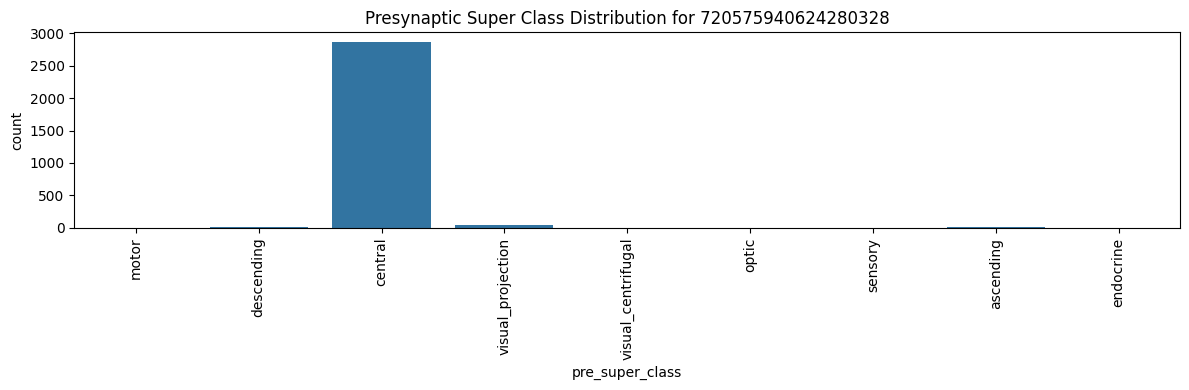

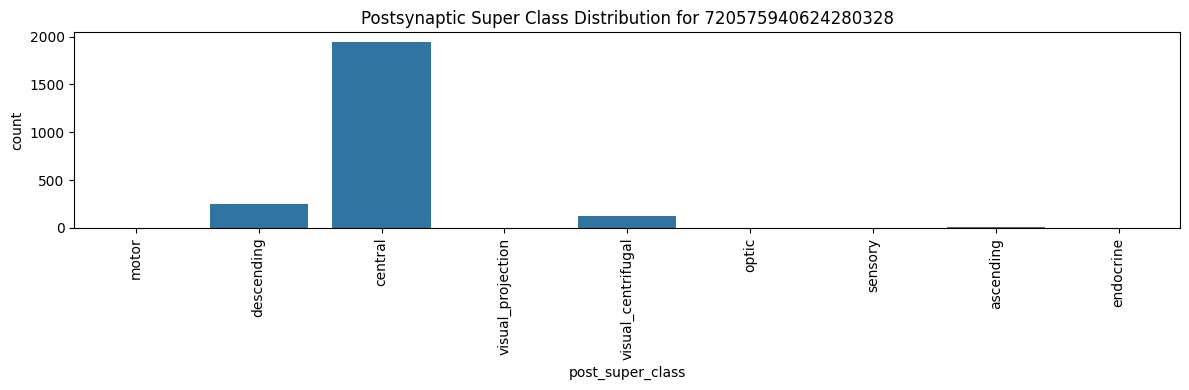


--- Flow Analysis ---


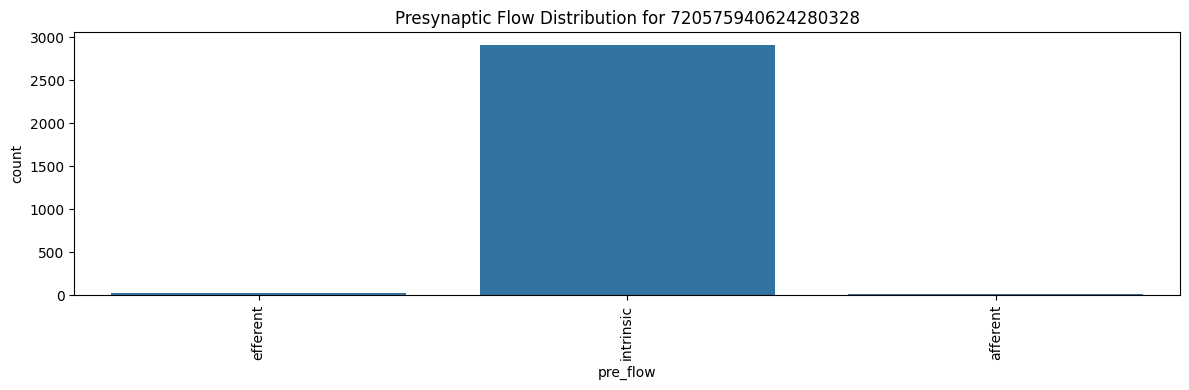

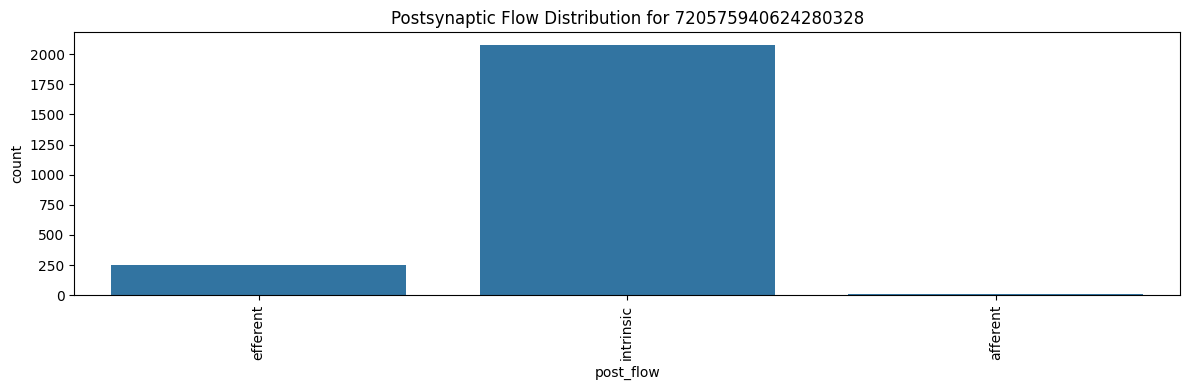


--- Class Analysis ---


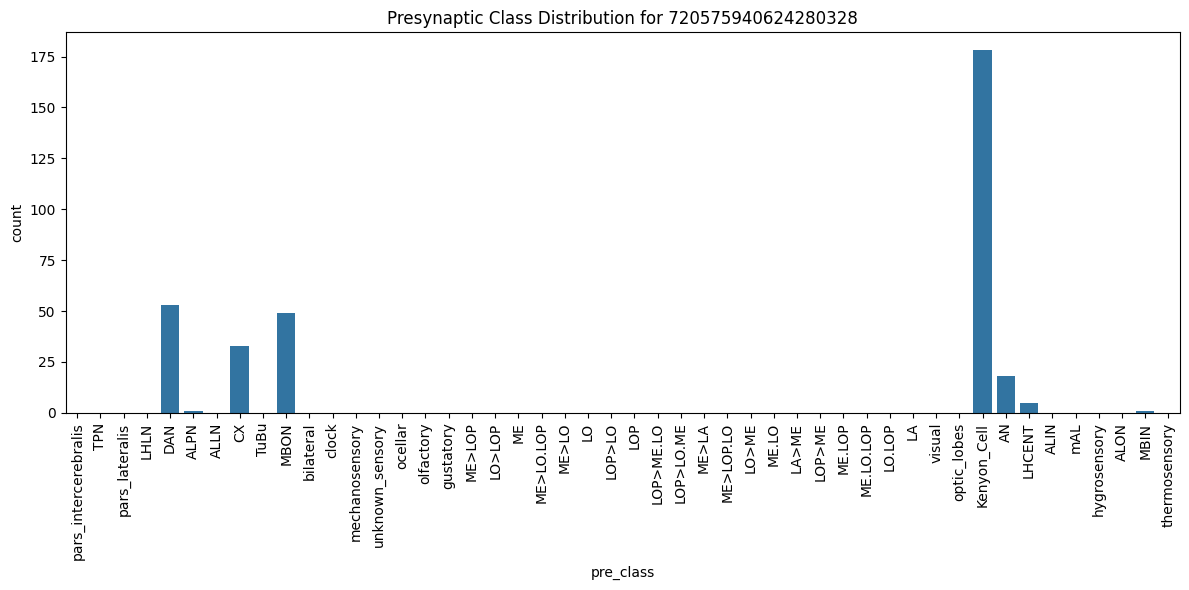

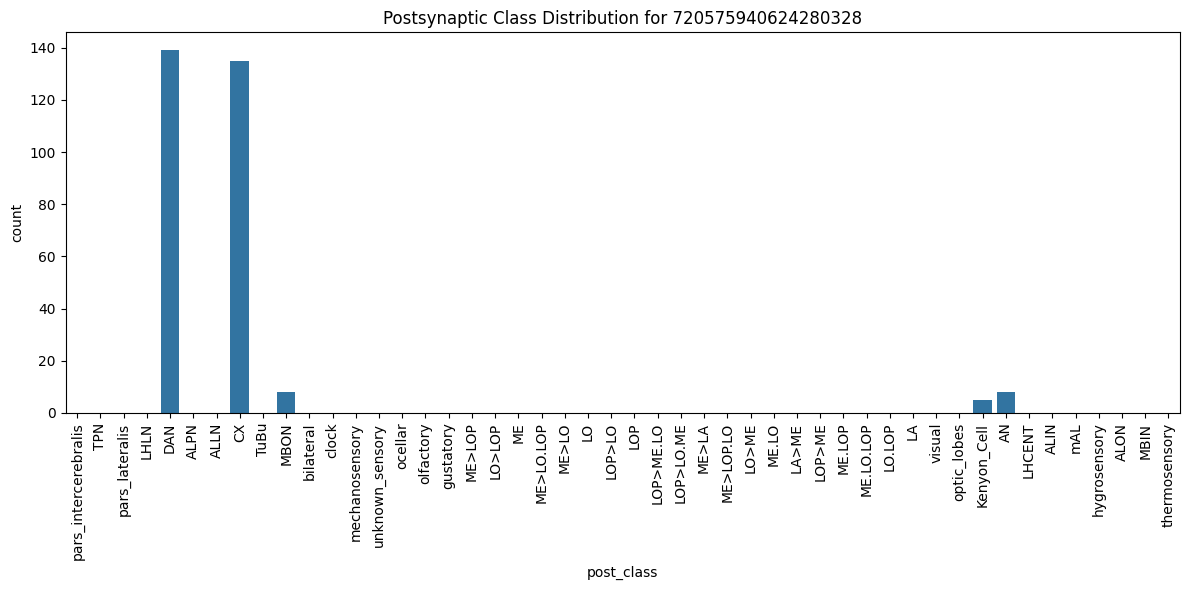


--- Top 20 Cell Types Analysis ---
No presynaptic top 20 cell type data to plot for 720575940624280328.
No postsynaptic top 20 cell type data to plot for 720575940624280328.
Analysis for Root ID: 720575940624280328 complete.
Finished generating synaptic distribution plots for all specified root IDs.


In [6]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# Re-prepare all necessary annotation dataframes and their respective 'pre_' and 'post_' versions,
# along with unique categories for plotting, to ensure they are in scope for this cell.

# Super Class Annotations
super_class_annos_df = client.materialize.query_table("hierarchical_neuron_annotations", filter_equal_dict={"classification_system": "super_class"})
unique_super_class = super_class_annos_df["cell_type"].unique()

pre_super_class_annos_df = super_class_annos_df[["pt_root_id", "cell_type"]].rename(
    columns={"pt_root_id": "pre_pt_root_id", "cell_type": "pre_super_class"})
post_super_class_annos_df = super_class_annos_df[["pt_root_id", "cell_type"]].rename(
    columns={"pt_root_id": "post_pt_root_id", "cell_type": "post_super_class"})

# Flow Annotations
flow_annos_df = client.materialize.query_table("hierarchical_neuron_annotations", filter_equal_dict={"classification_system": "flow"})
unique_flow = flow_annos_df["cell_type"].unique()

pre_flow_annos_df = flow_annos_df[["pt_root_id", "cell_type"]].rename(
    columns={"pt_root_id": "pre_pt_root_id", "cell_type": "pre_flow"})
post_flow_annos_df = flow_annos_df[["pt_root_id", "cell_type"]].rename(
    columns={"pt_root_id": "post_pt_root_id", "cell_type": "post_flow"})

# Class Annotations
cell_class_type_annos_df = client.materialize.query_table("hierarchical_neuron_annotations", filter_in_dict={"classification_system": ["cell_class", "cell_type"]})
class_annos_df = cell_class_type_annos_df[cell_class_type_annos_df['classification_system'] == 'cell_class']
unique_class = class_annos_df["cell_type"].unique()

pre_class_annos_df = class_annos_df[["pt_root_id", "cell_type"]].rename(
    columns={"pt_root_id": "pre_pt_root_id", "cell_type": "pre_class"})
post_class_annos_df = class_annos_df[["pt_root_id", "cell_type"]].rename(
    columns={"pt_root_id": "post_pt_root_id", "cell_type": "post_class"})

# Cell Type Annotations
cell_type_annos_df = cell_class_type_annos_df[cell_class_type_annos_df['classification_system'] == 'cell_type']
unique_cell_type = cell_type_annos_df["cell_type"].unique()
# Using top_20_cell_types as defined in an earlier cell, correcting the usage from top_10_cell_types
top_20_cell_types = cell_type_annos_df['cell_type'].value_counts().nlargest(20).index.tolist()

pre_cell_type_annos_df = cell_type_annos_df[["pt_root_id", "cell_type"]].rename(
    columns={"pt_root_id": "pre_pt_root_id", "cell_type": "pre_cell_type"})
post_cell_type_annos_df = cell_type_annos_df[["pt_root_id", "cell_type"]].rename(
    columns={"pt_root_id": "post_pt_root_id", "cell_type": "post_cell_type"})

def plot_synaptic_distributions(root_id):
    print(f"\n--- Analyzing Synaptic Distributions for Root ID: {root_id} ---")

    # 1. Load presynaptic and postsynaptic dataframes for the given root_id
    presyn_df = client.materialize.query_view("valid_synapses_nt_np_v6", filter_in_dict={"pre_pt_root_id": [root_id]})
    postsyn_df = client.materialize.query_view("valid_synapses_nt_np_v6", filter_in_dict={"post_pt_root_id": [root_id]})

    print(f"Found {len(presyn_df)} presynapses and {len(postsyn_df)} postsynapses for {root_id}.")

    # 2. For Super Class analysis
    print("\n--- Super Class Analysis ---")
    post_syn_super_df = pd.merge(postsyn_df, pre_super_class_annos_df, on="pre_pt_root_id")
    pre_syn_super_df = pd.merge(presyn_df, post_super_class_annos_df, on="post_pt_root_id")

    if not post_syn_super_df.empty:
        plt.subplots(figsize=(12, 4))
        sns.countplot(post_syn_super_df, x="pre_super_class", order=unique_super_class)
        plt.xticks(rotation=90)
        plt.title(f"Presynaptic Super Class Distribution for {root_id}")
        plt.tight_layout()
        plt.show()
    else:
        print(f"No presynaptic Super Class data to plot for {root_id}.")

    if not pre_syn_super_df.empty:
        plt.subplots(figsize=(12, 4))
        sns.countplot(pre_syn_super_df, x="post_super_class", order=unique_super_class)
        plt.xticks(rotation=90)
        plt.title(f"Postsynaptic Super Class Distribution for {root_id}")
        plt.tight_layout()
        plt.show()
    else:
        print(f"No postsynaptic Super Class data to plot for {root_id}.")

    # 3. For Flow analysis
    print("\n--- Flow Analysis ---")
    post_syn_flow_df = pd.merge(postsyn_df, pre_flow_annos_df, on="pre_pt_root_id")
    pre_syn_flow_df = pd.merge(presyn_df, post_flow_annos_df, on="post_pt_root_id")

    if not post_syn_flow_df.empty:
        plt.subplots(figsize=(12, 4))
        sns.countplot(post_syn_flow_df, x="pre_flow", order=unique_flow)
        plt.xticks(rotation=90)
        plt.title(f"Presynaptic Flow Distribution for {root_id}")
        plt.tight_layout()
        plt.show()
    else:
        print(f"No presynaptic Flow data to plot for {root_id}.")

    if not pre_syn_flow_df.empty:
        plt.subplots(figsize=(12, 4))
        sns.countplot(pre_syn_flow_df, x="post_flow", order=unique_flow)
        plt.xticks(rotation=90)
        plt.title(f"Postsynaptic Flow Distribution for {root_id}")
        plt.tight_layout()
        plt.show()
    else:
        print(f"No postsynaptic Flow data to plot for {root_id}.")

    # 4. For Class analysis
    print("\n--- Class Analysis ---")
    post_syn_class_df = pd.merge(postsyn_df, pre_class_annos_df, on="pre_pt_root_id")
    pre_syn_class_df = pd.merge(presyn_df, post_class_annos_df, on="post_pt_root_id")

    if not post_syn_class_df.empty:
        plt.subplots(figsize=(12, 6))
        sns.countplot(post_syn_class_df, x="pre_class", order=unique_class)
        plt.xticks(rotation=90)
        plt.title(f"Presynaptic Class Distribution for {root_id}")
        plt.tight_layout()
        plt.show()
    else:
        print(f"No presynaptic Class data to plot for {root_id}.")

    if not pre_syn_class_df.empty:
        plt.subplots(figsize=(12, 6))
        sns.countplot(pre_syn_class_df, x="post_class", order=unique_class)
        plt.xticks(rotation=90)
        plt.title(f"Postsynaptic Class Distribution for {root_id}")
        plt.tight_layout()
        plt.show()
    else:
        print(f"No postsynaptic Class data to plot for {root_id}.")

    # 5. For All Cell Types analysis (now using top_20_cell_types)
    print("\n--- Top 20 Cell Types Analysis ---")
    post_syn_cell_type_df = pd.merge(postsyn_df, pre_cell_type_annos_df, on="pre_pt_root_id", how='left').dropna(subset=['pre_cell_type'])
    pre_syn_cell_type_df = pd.merge(presyn_df, post_cell_type_annos_df, on="post_pt_root_id", how='left').dropna(subset=['post_cell_type'])

    post_syn_cell_type_df_filtered = post_syn_cell_type_df[post_syn_cell_type_df['pre_cell_type'].isin(top_20_cell_types)]
    pre_syn_cell_type_df_filtered = pre_syn_cell_type_df[pre_syn_cell_type_df['post_cell_type'].isin(top_20_cell_types)]

    if not post_syn_cell_type_df_filtered.empty:
        plt.subplots(figsize=(12, 6))
        sns.countplot(post_syn_cell_type_df_filtered, x="pre_cell_type", order=top_20_cell_types)
        plt.xticks(rotation=90)
        plt.title(f"Presynaptic Top 20 Cell Type Distribution for {root_id}")
        plt.tight_layout()
        plt.show()
    else:
        print(f"No presynaptic top 20 cell type data to plot for {root_id}.")

    if not pre_syn_cell_type_df_filtered.empty:
        plt.subplots(figsize=(12, 6))
        sns.countplot(pre_syn_cell_type_df_filtered, x="post_cell_type", order=top_20_cell_types)
        plt.xticks(rotation=90)
        plt.title(f"Postsynaptic Top 20 Cell Type Distribution for {root_id}")
        plt.tight_layout()
        plt.show()
    else:
        print(f"No postsynaptic top 20 cell type data to plot for {root_id}.")
    print(f"Analysis for Root ID: {root_id} complete.")

print("plot_synaptic_distributions function updated (locally redefined to show top 20 cell types).")

root_ids_to_analyze = [
720575940623182847,720575940624280328]

print("Generating synaptic distribution plots for the specified root IDs...")
for root_id in root_ids_to_analyze:
    plot_synaptic_distributions(root_id)

print("Finished generating synaptic distribution plots for all specified root IDs.")

# Discussion

Thats a lot of individual graphs. Lets talk visualization. Have you heard of heat maps? Google search for one and discuss with your partner if that is a useful way of visualizing this data.



## heatmap_plotting_function

### Subtask:
Create a new Python function `plot_cell_type_heatmaps(root_ids_to_analyze)` that generates two heatmaps visualizing the distribution of pre- and post-synaptic cell types for a given list of root IDs.


**Reasoning**:
The subtask requires defining a Python function `plot_cell_type_heatmaps` that processes synaptic data for multiple root IDs and generates heatmaps. This code block will define the function according to the instructions.



**Reasoning**:
The `plot_cell_type_heatmaps` function has been updated to handle potential non-numeric values. Now, I need to re-execute the complete code block that initializes the client, prepares the annotation dataframes, defines the `root_ids_to_analyze` list, and then calls the corrected `plot_cell_type_heatmaps` function. This will ensure all variables are correctly set up and the heatmaps are generated without errors.



# Task
Modify the `plot_cell_type_heatmaps` function to normalize cell type counts into proportions for both presynaptic and postsynaptic partners (such that proportions sum to 1 for each root ID), apply a count threshold before normalization, adjust heatmap titles to reflect proportions, and integrate `seaborn.clustermap` to enable clustering of root IDs based on their connectivity profiles in both presynaptic and postsynaptic heatmaps.

## Modify plot_cell_type_heatmaps for Normalization

### Subtask:
Update the `plot_cell_type_heatmaps` function to calculate proportions of cell types (summing to 1 for each root ID) for both presynaptic and postsynaptic partners, after applying the count threshold but before plotting. Also, adjust the titles of the heatmaps to reflect that proportions are being displayed.


**Reasoning**:
The subtask requires updating the `plot_cell_type_heatmaps` function to normalize the cell type counts to proportions and to update the heatmap titles accordingly. I will provide the complete modified function within a code block, along with the necessary setup code from previous steps, to ensure a self-contained and runnable solution.



plot_cell_type_heatmaps, plot_neurotransmitter_heatmaps, plot_super_class_heatmaps, and plot_class_heatmaps functions updated.
Client already initialized.
Required Cell Type annotation dataframes already prepared.
Neurotransmitter annotation dataframes already prepared.
Super Class annotation dataframes already prepared.
Class annotation dataframes already prepared.
root_ids_to_analyze already defined.

--- Generating Cell Type Heatmaps for 2 Root IDs ---
Processing Root ID: 720575940623182847


/tmp/ipython-input-3230094982.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_viridis = cm.get_cmap("viridis")


Processing Root ID: 720575940624280328


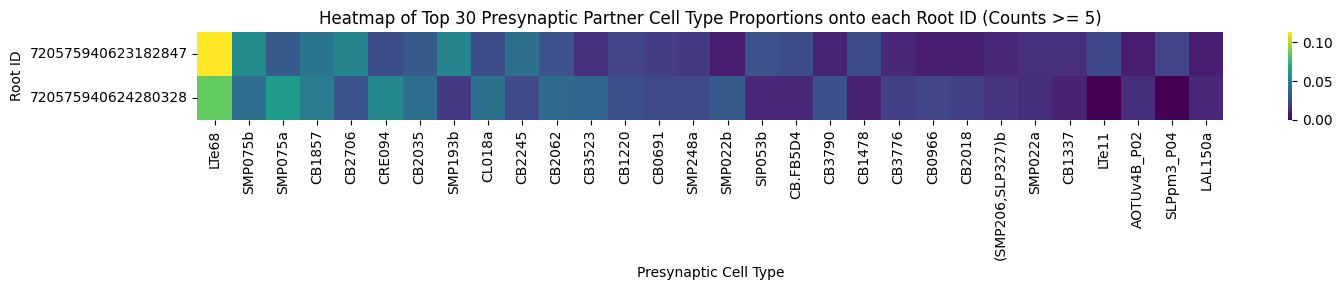

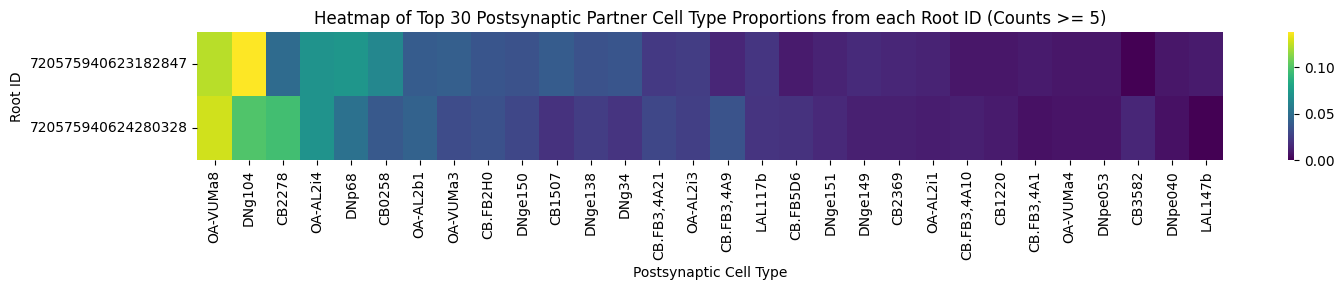

Cell Type Heatmap generation complete.

--- Generating Neurotransmitter Heatmaps for 2 Root IDs ---
Processing Root ID: 720575940623182847


/tmp/ipython-input-3230094982.py:127: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_viridis = cm.get_cmap("viridis")


Processing Root ID: 720575940624280328
No postsynaptic neurotransmitter data available to generate heatmap.
No presynaptic neurotransmitter data available to generate heatmap.
Neurotransmitter Heatmap generation complete.

--- Generating Super Class Heatmaps for 2 Root IDs ---
Processing Root ID: 720575940623182847


/tmp/ipython-input-3230094982.py:222: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_viridis = cm.get_cmap("viridis")


Processing Root ID: 720575940624280328


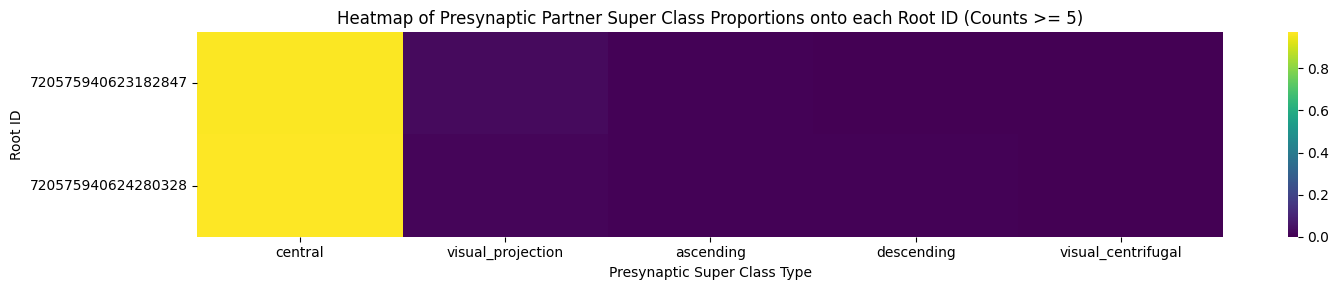

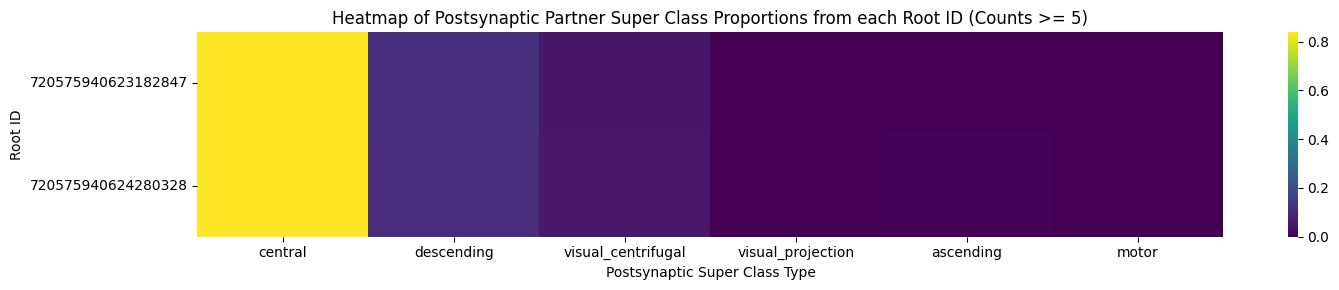

Super Class Heatmap generation complete.

--- Generating Class Heatmaps for 2 Root IDs ---
Processing Root ID: 720575940623182847


/tmp/ipython-input-3230094982.py:317: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_viridis = cm.get_cmap("viridis")


Processing Root ID: 720575940624280328


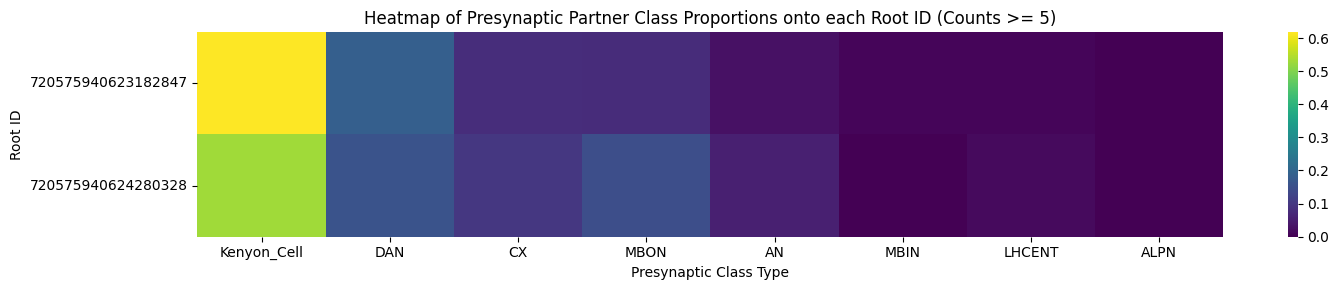

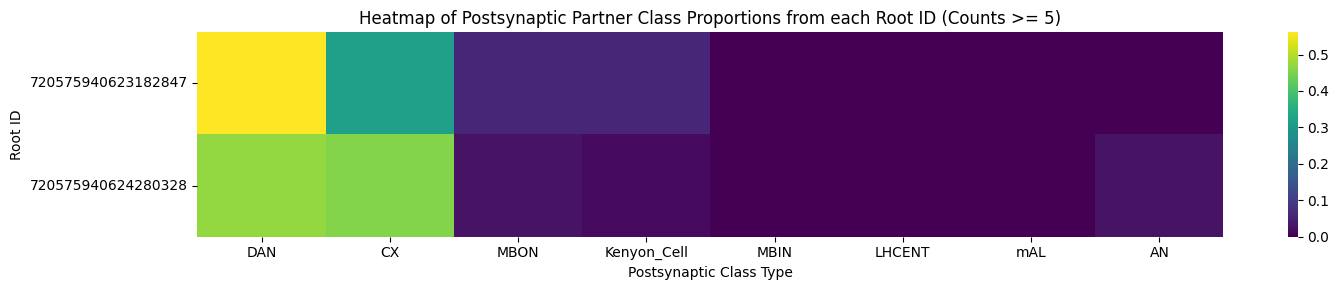

Class Heatmap generation complete.


In [8]:
import numpy as np
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import caveclient

def plot_cell_type_heatmaps(root_ids_to_analyze):
    """
    Generates two heatmaps visualizing the distribution of pre- and post-synaptic cell types
    for a given list of root IDs, showing proportions after applying a count threshold.

    Args:
        root_ids_to_analyze (list): A list of neuron root IDs to analyze.
    """
    print(f"\n--- Generating Cell Type Heatmaps for {len(root_ids_to_analyze)} Root IDs ---")

    # Initialize empty lists to store aggregated distributions
    all_pre_syn_cell_type_dist = []
    all_post_syn_cell_type_dist = []

    # Create a custom colormap with a defined 'bad' color for NaNs
    cmap_viridis = cm.get_cmap("viridis")
    cmap_viridis.set_bad(color='lightgrey') # Set NaN values to lightgrey

    for root_id in root_ids_to_analyze:
        print(f"Processing Root ID: {root_id}")

        # a. Query postsynaptic connections (partners synapsing *onto* root_id)
        postsyn_df = client.materialize.query_view("valid_synapses_nt_np_v6", filter_in_dict={"post_pt_root_id": [root_id]})

        # b. Query presynaptic connections (partners that root_id synapses *onto*)
        presyn_df = client.materialize.query_view("valid_synapses_nt_np_v6", filter_in_dict={"pre_pt_root_id": [root_id]})

        # c. Merge postsynaptic connections with pre_cell_type_annos_df
        #    To find cell type of incoming partners (pre-synaptic to current root_id)
        post_syn_partners_merged = pd.merge(postsyn_df, pre_cell_type_annos_df, on="pre_pt_root_id", how='left')

        # d. Merge presynaptic connections with post_cell_type_annos_df
        #    To find cell type of outgoing partners (post-synaptic to current root_id)
        pre_syn_partners_merged = pd.merge(presyn_df, post_cell_type_annos_df, on="post_pt_root_id", how='left')

        # e. Calculate value counts for pre-synaptic cell types synapsing onto current root_id
        if not post_syn_partners_merged.empty:
            # Explicitly drop NaN cell types before value_counts to ensure numeric output
            current_post_syn_dist = post_syn_partners_merged['pre_cell_type'].dropna().value_counts().to_frame().T
            current_post_syn_dist.index = [root_id]
            all_post_syn_cell_type_dist.append(current_post_syn_dist)

        # f. Calculate value counts for post-synaptic cell types that current root_id synapses onto
        if not pre_syn_partners_merged.empty:
            # Explicitly drop NaN cell types before value_counts to ensure numeric output
            current_pre_syn_dist = pre_syn_partners_merged['post_cell_type'].dropna().value_counts().to_frame().T
            current_pre_syn_dist.index = [root_id]
            all_pre_syn_cell_type_dist.append(current_pre_syn_dist)

    # 5. Concatenate and fill missing values, then explicitly cast to float
    if all_post_syn_cell_type_dist:
        final_post_syn_dist_df = pd.concat(all_post_syn_cell_type_dist, sort=False).fillna(0).astype(float)
        # Apply threshold: replace values below 5 with NaN
        post_syn_temp_df = final_post_syn_dist_df.copy()
        post_syn_temp_df[post_syn_temp_df < 5] = np.nan
        # Normalize non-NaN values in each row to sum to 1
        final_post_syn_dist_df = post_syn_temp_df.div(post_syn_temp_df.sum(axis=1), axis=0).fillna(0)
        # Select top 30 columns based on sum of proportions
        top_30_post_cols = final_post_syn_dist_df.sum().nlargest(30).index
        final_post_syn_dist_df = final_post_syn_dist_df[top_30_post_cols]

    else:
        final_post_syn_dist_df = pd.DataFrame()

    if all_pre_syn_cell_type_dist:
        final_pre_syn_dist_df = pd.concat(all_pre_syn_cell_type_dist, sort=False).fillna(0).astype(float)
        # Apply threshold: replace values below 5 with NaN
        pre_syn_temp_df = final_pre_syn_dist_df.copy()
        pre_syn_temp_df[pre_syn_temp_df < 5] = np.nan
        # Normalize non-NaN values in each row to sum to 1
        final_pre_syn_dist_df = pre_syn_temp_df.div(pre_syn_temp_df.sum(axis=1), axis=0).fillna(0)
        # Select top 30 columns based on sum of proportions
        top_30_pre_cols = final_pre_syn_dist_df.sum().nlargest(30).index
        final_pre_syn_dist_df = final_pre_syn_dist_df[top_30_pre_cols]
    else:
        final_pre_syn_dist_df = pd.DataFrame()

    # 6. Generate and display the first heatmap (Presynaptic partners to root_id)
    if not final_post_syn_dist_df.empty:
        plt.figure(figsize=(15, len(root_ids_to_analyze) * 0.5 + 2))
        sns.heatmap(final_post_syn_dist_df, annot=False, fmt=".2f", cmap=cmap_viridis) # fmt=".2f" for proportions
        plt.title('Heatmap of Top 30 Presynaptic Partner Cell Type Proportions onto each Root ID (Counts >= 5)')
        plt.xlabel('Presynaptic Cell Type')
        plt.ylabel('Root ID')
        plt.tight_layout()
        plt.show()
    else:
        print("No postsynaptic data available to generate heatmap.")

    # 7. Generate and display the second heatmap (Postsnyaptic partners from root_id)
    if not final_pre_syn_dist_df.empty:
        plt.figure(figsize=(15, len(root_ids_to_analyze) * 0.5 + 2))
        sns.heatmap(final_pre_syn_dist_df, annot=False, fmt=".2f", cmap=cmap_viridis) # fmt=".2f" for proportions
        plt.title('Heatmap of Top 30 Postsynaptic Partner Cell Type Proportions from each Root ID (Counts >= 5)')
        plt.xlabel('Postsynaptic Cell Type')
        plt.ylabel('Root ID')
        plt.tight_layout()
        plt.show()
    else:
        print("No presynaptic data available to generate heatmap.")

    print("Cell Type Heatmap generation complete.")

def plot_neurotransmitter_heatmaps(root_ids_to_analyze):
    """
    Generates two heatmaps visualizing the distribution of pre- and post-synaptic
    neurotransmitter types for a given list of root IDs, showing proportions after
    applying a count threshold.

    Args:
        root_ids_to_analyze (list): A list of neuron root IDs to analyze.
    """
    print(f"\n--- Generating Neurotransmitter Heatmaps for {len(root_ids_to_analyze)} Root IDs ---")

    # Initialize empty lists to store aggregated distributions
    all_pre_syn_nt_dist = []
    all_post_syn_nt_dist = []

    # Create a custom colormap with a defined 'bad' color for NaNs
    cmap_viridis = cm.get_cmap("viridis")
    cmap_viridis.set_bad(color='lightgrey') # Set NaN values to lightgrey

    for root_id in root_ids_to_analyze:
        print(f"Processing Root ID: {root_id}")

        # Query postsynaptic connections (partners synapsing *onto* root_id)
        postsyn_df = client.materialize.query_view("valid_synapses_nt_np_v6", filter_in_dict={"post_pt_root_id": [root_id]})

        # Query presynaptic connections (partners that root_id synapses *onto*)
        presyn_df = client.materialize.query_view("valid_synapses_nt_np_v6", filter_in_dict={"pre_pt_root_id": [root_id]})

        # Merge postsynaptic connections with pre_neurotransmitter_annos_df
        # To find neurotransmitter type of incoming partners (pre-synaptic to current root_id)
        post_syn_partners_merged = pd.merge(postsyn_df, pre_neurotransmitter_annos_df, on="pre_pt_root_id", how='left')

        # Merge presynaptic connections with post_neurotransmitter_annos_df
        # To find neurotransmitter type of outgoing partners (post-synaptic to current root_id)
        pre_syn_partners_merged = pd.merge(presyn_df, post_neurotransmitter_annos_df, on="post_pt_root_id", how='left')

        # Calculate value counts for pre-synaptic neurotransmitter types synapsing onto current root_id
        if not post_syn_partners_merged.empty:
            current_post_syn_nt_dist = post_syn_partners_merged['pre_neurotransmitter'].dropna().value_counts().to_frame().T
            current_post_syn_nt_dist.index = [root_id]
            all_post_syn_nt_dist.append(current_post_syn_nt_dist)

        # Calculate value counts for post-synaptic neurotransmitter types that current root_id synapses onto
        if not pre_syn_partners_merged.empty:
            current_pre_syn_nt_dist = pre_syn_partners_merged['post_neurotransmitter'].dropna().value_counts().to_frame().T
            current_pre_syn_nt_dist.index = [root_id]
            all_pre_syn_nt_dist.append(current_pre_syn_nt_dist)

    # Concatenate and fill missing values, then explicitly cast to float
    if all_post_syn_nt_dist:
        final_post_syn_nt_dist_df = pd.concat(all_post_syn_nt_dist, sort=False).fillna(0).astype(float)
        # Apply threshold: replace values below 5 with NaN
        post_syn_nt_temp_df = final_post_syn_nt_dist_df.copy()
        post_syn_nt_temp_df[post_syn_nt_temp_df < 5] = np.nan
        # Normalize non-NaN values in each row to sum to 1
        final_post_syn_nt_dist_df = post_syn_nt_temp_df.div(post_syn_nt_temp_df.sum(axis=1), axis=0).fillna(0)
    else:
        final_post_syn_nt_dist_df = pd.DataFrame()

    if all_pre_syn_nt_dist:
        final_pre_syn_nt_dist_df = pd.concat(all_pre_syn_nt_dist, sort=False).fillna(0).astype(float)
        # Apply threshold: replace values below 5 with NaN
        pre_syn_nt_temp_df = final_pre_syn_nt_dist_df.copy()
        pre_syn_nt_temp_df[pre_syn_nt_temp_df < 5] = np.nan
        # Normalize non-NaN values in each row to sum to 1
        final_pre_syn_nt_dist_df = pre_syn_nt_temp_df.div(pre_syn_nt_temp_df.sum(axis=1), axis=0).fillna(0)
    else:
        final_pre_syn_nt_dist_df = pd.DataFrame()

    # Generate and display the first heatmap (Presynaptic partners to root_id)
    if not final_post_syn_nt_dist_df.empty:
        plt.figure(figsize=(15, len(root_ids_to_analyze) * 0.5 + 2))
        sns.heatmap(final_post_syn_nt_dist_df, annot=False, fmt=".2f", cmap=cmap_viridis)
        plt.title('Heatmap of Presynaptic Partner Neurotransmitter Proportions onto each Root ID (Counts >= 5)')
        plt.xlabel('Presynaptic Neurotransmitter Type')
        plt.ylabel('Root ID')
        plt.tight_layout()
        plt.show()
    else:
        print("No postsynaptic neurotransmitter data available to generate heatmap.")

    # Generate and display the second heatmap (Postsnyaptic partners from root_id)
    if not final_pre_syn_nt_dist_df.empty:
        plt.figure(figsize=(15, len(root_ids_to_analyze) * 0.5 + 2))
        sns.heatmap(final_pre_syn_nt_dist_df, annot=False, fmt=".2f", cmap=cmap_viridis)
        plt.title('Heatmap of Postsynaptic Partner Neurotransmitter Proportions from each Root ID (Counts >= 5)')
        plt.xlabel('Postsynaptic Neurotransmitter Type')
        plt.ylabel('Root ID')
        plt.tight_layout()
        plt.show()
    else:
        print("No presynaptic neurotransmitter data available to generate heatmap.")

    print("Neurotransmitter Heatmap generation complete.")

def plot_super_class_heatmaps(root_ids_to_analyze):
    """
    Generates two heatmaps visualizing the distribution of pre- and post-synaptic
    super_class types for a given list of root IDs, showing proportions after
    applying a count threshold.

    Args:
        root_ids_to_analyze (list): A list of neuron root IDs to analyze.
    """
    print(f"\n--- Generating Super Class Heatmaps for {len(root_ids_to_analyze)} Root IDs ---")

    # Initialize empty lists to store aggregated distributions
    all_pre_syn_super_class_dist = []
    all_post_syn_super_class_dist = []

    # Create a custom colormap with a defined 'bad' color for NaNs
    cmap_viridis = cm.get_cmap("viridis")
    cmap_viridis.set_bad(color='lightgrey') # Set NaN values to lightgrey

    for root_id in root_ids_to_analyze:
        print(f"Processing Root ID: {root_id}")

        # Query postsynaptic connections (partners synapsing *onto* root_id)
        postsyn_df = client.materialize.query_view("valid_synapses_nt_np_v6", filter_in_dict={"post_pt_root_id": [root_id]})

        # Query presynaptic connections (partners that root_id synapses *onto*)
        presyn_df = client.materialize.query_view("valid_synapses_nt_np_v6", filter_in_dict={"pre_pt_root_id": [root_id]})

        # Merge postsynaptic connections with pre_super_class_annos_df
        # To find super_class type of incoming partners (pre-synaptic to current root_id)
        post_syn_partners_merged = pd.merge(postsyn_df, pre_super_class_annos_df, on="pre_pt_root_id", how='left')

        # Merge presynaptic connections with post_super_class_annos_df
        # To find super_class type of outgoing partners (post-synaptic to current root_id)
        pre_syn_partners_merged = pd.merge(presyn_df, post_super_class_annos_df, on="post_pt_root_id", how='left')

        # Calculate value counts for pre-synaptic super_class types synapsing onto current root_id
        if not post_syn_partners_merged.empty:
            current_post_syn_super_class_dist = post_syn_partners_merged['pre_super_class'].dropna().value_counts().to_frame().T
            current_post_syn_super_class_dist.index = [root_id]
            all_post_syn_super_class_dist.append(current_post_syn_super_class_dist)

        # Calculate value counts for post-synaptic super_class types that current root_id synapses onto
        if not pre_syn_partners_merged.empty:
            current_pre_syn_super_class_dist = pre_syn_partners_merged['post_super_class'].dropna().value_counts().to_frame().T
            current_pre_syn_super_class_dist.index = [root_id]
            all_pre_syn_super_class_dist.append(current_pre_syn_super_class_dist)

    # Concatenate and fill missing values, then explicitly cast to float
    if all_post_syn_super_class_dist:
        final_post_syn_super_class_dist_df = pd.concat(all_post_syn_super_class_dist, sort=False).fillna(0).astype(float)
        # Apply threshold: replace values below 5 with NaN
        post_syn_super_class_temp_df = final_post_syn_super_class_dist_df.copy()
        post_syn_super_class_temp_df[post_syn_super_class_temp_df < 5] = np.nan
        # Normalize non-NaN values in each row to sum to 1
        final_post_syn_super_class_dist_df = post_syn_super_class_temp_df.div(post_syn_super_class_temp_df.sum(axis=1), axis=0).fillna(0)
    else:
        final_post_syn_super_class_dist_df = pd.DataFrame()

    if all_pre_syn_super_class_dist:
        final_pre_syn_super_class_dist_df = pd.concat(all_pre_syn_super_class_dist, sort=False).fillna(0).astype(float)
        # Apply threshold: replace values below 5 with NaN
        pre_syn_super_class_temp_df = final_pre_syn_super_class_dist_df.copy()
        pre_syn_super_class_temp_df[pre_syn_super_class_temp_df < 5] = np.nan
        # Normalize non-NaN values in each row to sum to 1
        final_pre_syn_super_class_dist_df = pre_syn_super_class_temp_df.div(pre_syn_super_class_temp_df.sum(axis=1), axis=0).fillna(0)
    else:
        final_pre_syn_super_class_dist_df = pd.DataFrame()

    # Generate and display the first heatmap (Presynaptic partners to root_id)
    if not final_post_syn_super_class_dist_df.empty:
        plt.figure(figsize=(15, len(root_ids_to_analyze) * 0.5 + 2))
        sns.heatmap(final_post_syn_super_class_dist_df, annot=False, fmt=".2f", cmap=cmap_viridis)
        plt.title('Heatmap of Presynaptic Partner Super Class Proportions onto each Root ID (Counts >= 5)')
        plt.xlabel('Presynaptic Super Class Type')
        plt.ylabel('Root ID')
        plt.tight_layout()
        plt.show()
    else:
        print("No postsynaptic super_class data available to generate heatmap.")

    # Generate and display the second heatmap (Postsnyaptic partners from root_id)
    if not final_pre_syn_super_class_dist_df.empty:
        plt.figure(figsize=(15, len(root_ids_to_analyze) * 0.5 + 2))
        sns.heatmap(final_pre_syn_super_class_dist_df, annot=False, fmt=".2f", cmap=cmap_viridis)
        plt.title('Heatmap of Postsynaptic Partner Super Class Proportions from each Root ID (Counts >= 5)')
        plt.xlabel('Postsynaptic Super Class Type')
        plt.ylabel('Root ID')
        plt.tight_layout()
        plt.show()
    else:
        print("No presynaptic super_class data available to generate heatmap.")

    print("Super Class Heatmap generation complete.")

def plot_class_heatmaps(root_ids_to_analyze):
    """
    Generates two heatmaps visualizing the distribution of pre- and post-synaptic
    class types for a given list of root IDs, showing proportions after
    applying a count threshold.

    Args:
        root_ids_to_analyze (list): A list of neuron root IDs to analyze.
    """
    print(f"\n--- Generating Class Heatmaps for {len(root_ids_to_analyze)} Root IDs ---")

    # Initialize empty lists to store aggregated distributions
    all_pre_syn_class_dist = []
    all_post_syn_class_dist = []

    # Create a custom colormap with a defined 'bad' color for NaNs
    cmap_viridis = cm.get_cmap("viridis")
    cmap_viridis.set_bad(color='lightgrey') # Set NaN values to lightgrey

    for root_id in root_ids_to_analyze:
        print(f"Processing Root ID: {root_id}")

        # Query postsynaptic connections (partners synapsing *onto* root_id)
        postsyn_df = client.materialize.query_view("valid_synapses_nt_np_v6", filter_in_dict={"post_pt_root_id": [root_id]})

        # Query presynaptic connections (partners that root_id synapses *onto*)
        presyn_df = client.materialize.query_view("valid_synapses_nt_np_v6", filter_in_dict={"pre_pt_root_id": [root_id]})

        # Merge postsynaptic connections with pre_class_annos_df
        # To find class type of incoming partners (pre-synaptic to current root_id)
        post_syn_partners_merged = pd.merge(postsyn_df, pre_class_annos_df, on="pre_pt_root_id", how='left')

        # Merge presynaptic connections with post_class_annos_df
        # To find class type of outgoing partners (post-synaptic to current root_id)
        pre_syn_partners_merged = pd.merge(presyn_df, post_class_annos_df, on="post_pt_root_id", how='left')

        # Calculate value counts for pre-synaptic class types synapsing onto current root_id
        if not post_syn_partners_merged.empty:
            current_post_syn_class_dist = post_syn_partners_merged['pre_class'].dropna().value_counts().to_frame().T
            current_post_syn_class_dist.index = [root_id]
            all_post_syn_class_dist.append(current_post_syn_class_dist)

        # Calculate value counts for post-synaptic class types that current root_id synapses onto
        if not pre_syn_partners_merged.empty:
            current_pre_syn_class_dist = pre_syn_partners_merged['post_class'].dropna().value_counts().to_frame().T
            current_pre_syn_class_dist.index = [root_id]
            all_pre_syn_class_dist.append(current_pre_syn_class_dist)

    # Concatenate and fill missing values, then explicitly cast to float
    if all_post_syn_class_dist:
        final_post_syn_class_dist_df = pd.concat(all_post_syn_class_dist, sort=False).fillna(0).astype(float)
        # Apply threshold: replace values below 5 with NaN
        post_syn_class_temp_df = final_post_syn_class_dist_df.copy()
        post_syn_class_temp_df[post_syn_class_temp_df < 5] = np.nan
        # Normalize non-NaN values in each row to sum to 1
        final_post_syn_class_dist_df = post_syn_class_temp_df.div(post_syn_class_temp_df.sum(axis=1), axis=0).fillna(0)
    else:
        final_post_syn_class_dist_df = pd.DataFrame()

    if all_pre_syn_class_dist:
        final_pre_syn_class_dist_df = pd.concat(all_pre_syn_class_dist, sort=False).fillna(0).astype(float)
        # Apply threshold: replace values below 5 with NaN
        pre_syn_class_temp_df = final_pre_syn_class_dist_df.copy()
        pre_syn_class_temp_df[pre_syn_class_temp_df < 5] = np.nan
        # Normalize non-NaN values in each row to sum to 1
        final_pre_syn_class_dist_df = pre_syn_class_temp_df.div(pre_syn_class_temp_df.sum(axis=1), axis=0).fillna(0)
    else:
        final_pre_syn_class_dist_df = pd.DataFrame()

    # Generate and display the first heatmap (Presynaptic partners to root_id)
    if not final_post_syn_class_dist_df.empty:
        plt.figure(figsize=(15, len(root_ids_to_analyze) * 0.5 + 2))
        sns.heatmap(final_post_syn_class_dist_df, annot=False, fmt=".2f", cmap=cmap_viridis)
        plt.title('Heatmap of Presynaptic Partner Class Proportions onto each Root ID (Counts >= 5)')
        plt.xlabel('Presynaptic Class Type')
        plt.ylabel('Root ID')
        plt.tight_layout()
        plt.show()
    else:
        print("No postsynaptic class data available to generate heatmap.")

    # Generate and display the second heatmap (Postsnyaptic partners from root_id)
    if not final_pre_syn_class_dist_df.empty:
        plt.figure(figsize=(15, len(root_ids_to_analyze) * 0.5 + 2))
        sns.heatmap(final_pre_syn_class_dist_df, annot=False, fmt=".2f", cmap=cmap_viridis)
        plt.title('Heatmap of Postsynaptic Partner Class Proportions from each Root ID (Counts >= 5)')
        plt.xlabel('Postsynaptic Class Type')
        plt.ylabel('Root ID')
        plt.tight_layout()
        plt.show()
    else:
        print("No presynaptic class data available to generate heatmap.")

    print("Class Heatmap generation complete.")

print("plot_cell_type_heatmaps, plot_neurotransmitter_heatmaps, plot_super_class_heatmaps, and plot_class_heatmaps functions updated.")

# Re-initialize CAVEclient with the authentication token if not already present in the current session
# (Assuming my_token is defined from previous steps)
if 'client' not in locals() or client.auth.token != my_token:
    datastack_name = "flywire_fafb_public"
    client = caveclient.CAVEclient(datastack_name, auth_token=my_token)
    print("Client re-initialized.")
else:
    print("Client already initialized.")

# Re-prepare Cell Type Annotations specifically needed by plot_cell_type_heatmaps
if 'cell_class_type_annos_df' not in locals() or 'pre_cell_type_annos_df' not in locals():
    cell_class_type_annos_df = client.materialize.query_table("hierarchical_neuron_annotations", filter_in_dict={"classification_system": ["cell_class", "cell_type"]})
    cell_type_annos_df = cell_class_type_annos_df[cell_class_type_annos_df['classification_system'] == 'cell_type']

    pre_cell_type_annos_df = cell_type_annos_df[["pt_root_id", "cell_type"]].rename(
        columns={"pt_root_id": "pre_pt_root_id", "cell_type": "pre_cell_type"})
    post_cell_type_annos_df = cell_type_annos_df[["pt_root_id", "cell_type"]].rename(
        columns={"pt_root_id": "post_pt_root_id", "cell_type": "post_cell_type"})
    print("Required Cell Type annotation dataframes re-prepared.")
else:
    print("Required Cell Type annotation dataframes already prepared.")

# Prepare Neurotransmitter Annotations
if 'neurotransmitter_annos_df' not in locals():
    neurotransmitter_annos_df = client.materialize.query_table("hierarchical_neuron_annotations", filter_equal_dict={"classification_system": "neurotransmitter"})
    pre_neurotransmitter_annos_df = neurotransmitter_annos_df[["pt_root_id", "cell_type"]].rename(
        columns={"pt_root_id": "pre_pt_root_id", "cell_type": "pre_neurotransmitter"})
    post_neurotransmitter_annos_df = neurotransmitter_annos_df[["pt_root_id", "cell_type"]].rename(
        columns={"pt_root_id": "post_pt_root_id", "cell_type": "post_neurotransmitter"})
    print("Neurotransmitter annotation dataframes prepared.")
else:
    print("Neurotransmitter annotation dataframes already prepared.")

# Prepare Super Class Annotations
if 'super_class_annos_df' not in locals():
    super_class_annos_df = client.materialize.query_table("hierarchical_neuron_annotations", filter_equal_dict={"classification_system": "super_class"})
    pre_super_class_annos_df = super_class_annos_df[["pt_root_id", "cell_type"]].rename(
        columns={"pt_root_id": "pre_pt_root_id", "cell_type": "pre_super_class"})
    post_super_class_annos_df = super_class_annos_df[["pt_root_id", "cell_type"]].rename(
        columns={"pt_root_id": "post_pt_root_id", "cell_type": "post_super_class"})
    print("Super Class annotation dataframes prepared.")
else:
    print("Super Class annotation dataframes already prepared.")

# Prepare Class Annotations
if 'class_annos_df' not in locals():
    # Note: class_annos_df is already derived from cell_class_type_annos_df in 'Prepare Annotation DataFrames' section
    # Re-extract if not present
    if 'cell_class_type_annos_df' not in locals():
        cell_class_type_annos_df = client.materialize.query_table("hierarchical_neuron_annotations", filter_in_dict={"classification_system": ["cell_class", "cell_type"]})
    class_annos_df = cell_class_type_annos_df[cell_class_type_annos_df['classification_system'] == 'cell_class']
    pre_class_annos_df = class_annos_df[["pt_root_id", "cell_type"]].rename(
        columns={"pt_root_id": "pre_pt_root_id", "cell_type": "pre_class"})
    post_class_annos_df = class_annos_df[["pt_root_id", "cell_type"]].rename(
        columns={"pt_root_id": "post_pt_root_id", "cell_type": "post_class"})
    print("Class annotation dataframes prepared.")
else:
    print("Class annotation dataframes already prepared.")

# Define the root IDs to analyze (if not already defined)
if 'root_ids_to_analyze' not in locals():
    root_ids_to_analyze = [
   720575940623182847,720575940624280328
    ]
    print("root_ids_to_analyze defined.")
else:
    print("root_ids_to_analyze already defined.")

# Call the functions with the defined root IDs
plot_cell_type_heatmaps(root_ids_to_analyze)
plot_neurotransmitter_heatmaps(root_ids_to_analyze)
plot_super_class_heatmaps(root_ids_to_analyze)
plot_class_heatmaps(root_ids_to_analyze)
